**Intro**

This Jupyter Notebook has been created for the realization of the project **Partizione Antica. Looking for a XIXth century. art historian identity** as final project of the <a href="https://www.unibo.it/it/didattica/insegnamenti/insegnamento/2021/443749" target="_blank">90154 - Electronic Publishing and Digital Storytelling</a> course, taught by **Prof. Marilena Daquino**, in the framework of the 2nd year of the <a href="https://corsi.unibo.it/2cycle/DigitalHumanitiesKnowledge" target="_blank">DHDK Master Degree</a>, a.a. 2021-22.<br>
Here are listed the main steps faced:
       
    1. Data Preparation:
          1.0 creation of two complexive xml files for F and OA entries extracted from the Federico Zeri Foundation catalogues
          1.1 extraction of relevant information for the project from nested xml stucture and structuring them in plain tabular format
          1.2 extraction from previpus tabular data of unstructured annotations
          1.3 creation of a new database merging data from the two previous steps
    2. Data Elaboration: seeking for furter analysis elements via:
          2.1 deeper work on photographer for enhancing their information (workplace, timespan of activity, etc.)
          2.2 deeper work on places for enhancing their gelocation
          2.3 work on unstructured annotations trough NLP and NER
    3. Data Visualization
          3.O Data overview
          3.1 Depicted works of art typologies and geographic distribution
          3.2 Photographers and anonymous photos
          3.3 Annotations 
          3.4 Derived infos from annotations

# 1. Data preparation

This research started from a **record data extraction** of the Supino Partizione Antica fund provided from the Federico Zeri Foundation: the original data counted 3.260 records for photographs and 2.634 records for depicted works of art. <br>
The original data have been used for **illustrative and didactical purposes only**: all the credits and reuse authorizations must be asked to <a href="mailto:fondazionezeri.fototeca@unibo.it">Federico Zeri Foundation</a>.

## 1.0 Creation of the F and OA complexive xml files

To allow a better management and manipulation complexive files have been created via xquery collection command and published. 
They collect:

*   all the single photograph xml files' records in the F_entries.xml file (data/0_source_data)
*   all the single works of art xml files' records in the OA_entries.xml file (data/0_source_data)

## 1.1 XML metadata

Due to the hypernested and not consistently presence of elements at different levels, <pandas.read_xml> method was not effectively parsing what was needed.
The <xml.etree.ElementTree> library has then been preferred because it allows to call for single elements at different nesting levels. Nevertheless, this approach presents some drawbacks as the need of a previous and deep knowledge of the database structure that does not allow to uncover unexpected correlations possible through the exploration of a comprehensive dataset.

Preliminary libraries have been installed.

In [3]:
#preliminary imports
#!pip install python-csv
#!pip install elementpath
!pip install pandas

import xml.etree.ElementTree as ET
import csv
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 23.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 48.9 MB/s eta 0:00:0000:0100:01


In [4]:
#function to have back the element texts
def extract_data(path):
    if SCHEDA.find(path) != None:
        name = SCHEDA.find(path).text
    else:
        name = None
    return name

#parse the complexive Fxml and OAxml files
F_tree = ET.parse("data/0_source_data/F_entries.xml")
F_root = F_tree.getroot()
F_root.attrib["test"]

OA_tree = ET.parse("data/0_source_data/OA_entries.xml")
OA_root = OA_tree.getroot()
OA_root.attrib["test2"]

#set the colums' headers for the choosen elements
header = ["sercdf_F_ser", "sercdoa_OA_ser", "INVN_F", "UBFC_Fshelfmark", #ids
          "PVCS_OAcountry", "PVCC_OAtown", "LDCN_OArep", "PRVC_OAprev_town", "AUFI_Fatelier_address", #places
          "AUFN_Faut", "SGLT_Ftitle", "SGTT_OAtitle", "AUTN_OAaut", #authors/titles
          "OGTT_OAtype", "AUTB_Fsubj_main", "OGTDOA_OAsubj_sub", #subjects
          "ROFI_Fneg", "BIBA_OAbib",#external relations
          "OSS_Fnotes", "OSS_OAnotes", #unstructured infos
         "FTAN_filename", "NCTN_F_entry", "NRSCHEDA_OA_entry", #2ary ids
        "DTZG_OAcentury", "LRD_Fshotdates", "DTSI_Fprintdates", "DTSF_Fprintdates", "AUFA_Faut_dates"] #time

#setting an empty list
data = []

#iterate on F_entries - and on correspondig OA_entries -
#for extracting elements texts, store them in a list and add it to the data
#two fields from original data are futherly modify for our purposes

for SCHEDA in F_root.findall("SCHEDA"):
    oa_ser = SCHEDA.get("sercdoa")
    f_ser = SCHEDA.get("sercdf")
    inv = extract_data("./PARAGRAFO/INVN")
    container = extract_data("./PARAGRAFO/UBFT")
    shelf = extract_data("./PARAGRAFO/UBFC")
    title_f = extract_data("./PARAGRAFO/RIPETIZIONE/SGLT")
    aut_f = extract_data("./PARAGRAFO/RIPETIZIONE/AUFN") #the original data do not distinguish AUFN and AUFB for collective agents
    aut_f_dates = extract_data("./PARAGRAFO/RIPETIZIONE/AUFA")#timespan of photographer's actvity
    aut_f_addr = extract_data("./PARAGRAFO/RIPETIZIONE/AUFI")#place of photographer's actvity as reported in the photograph >AF of variants
    aut_oa = extract_data("./PARAGRAFO/RIPETIZIONE/AUTN")
    subj_main = extract_data("./PARAGRAFO/RIPETIZIONE/AUTB")
    subj_sub = extract_data("./PARAGRAFO/RIPETIZIONE/OGTDOA")
    notes_f = extract_data("./PARAGRAFO/OSS")
    neg_num = extract_data("./PARAGRAFO/ROFI")
    f_entry = extract_data("./PARAGRAFO/NCTN")
    filename = extract_data("./PARAGRAFO/FTAN")
    shotdates = extract_data("./PARAGRAFO/LRD")
    if shotdates != None:
        #reduce uncertainty: if /ante in field, put 1855 as conventional beginning date
        #for collodium negatives (accordign to other Zeri cataloguing)
        if "/ante" in shotdates:
            shotdates.replace("/ante", "/ ante")
        if "/ ante" in shotdates:
        #if re.match("/ante|\/ ante", shotdates):
            shotdates = "1855-"+shotdates[:-6]
    printdates_start = extract_data("./PARAGRAFO/DTSI")
    printdates_end = extract_data("./PARAGRAFO/DTSF")

    for SCHEDA in OA_root.findall("SCHEDA"):
        if SCHEDA.get("sercdoa") == oa_ser:
            title_oa = extract_data("./PARAGRAFO/SGTT")
            century_oa = extract_data("./PARAGRAFO/DTZG")
            country_oa = extract_data("./PARAGRAFO/PVCS") #Original data report just 2 LRCS: name of the country where the shot was taken.
            town_oa = extract_data("./PARAGRAFO/PVCC") #Original data report just 2 LRCC: name of the country where the shot was taken.
            rep_oa = extract_data("./PARAGRAFO/LDCN")
            prev_town_oa = extract_data("./PARAGRAFO/RIPETIZIONE/PRVC")
            if prev_town_oa != None:
                #save the previous locations only if in 1800-1899 timespan (PRDU) otherwise put "NR" (not relevant)
                if extract_data("./PARAGRAFO/RIPETIZIONE/PRDU") != None:
                    if "1799" < extract_data("./PARAGRAFO/RIPETIZIONE/PRDU") < "1900": #PRDU last date the OA was in that location
                        prev_town_oa = prev_town_oa + " | " + str(extract_data("./PARAGRAFO/RIPETIZIONE/PRDU"))
                    else:
                        prev_town_oa = "NR"
            type_oa = extract_data("./PARAGRAFO/OGTT")
            notes_oa = extract_data("./PARAGRAFO/OSS")
            oa_entry = extract_data("./PARAGRAFO/NRSCHEDA")
            beg_date_oa = extract_data("./PARAGRAFO/DTSI")
            if extract_data("./PARAGRAFO/RIPETIZIONE/BIBA") != None:
                #save the bib ref only if in 1800-1899 timespan (BIBD) otherwise put "NR" (not relevant)
                if extract_data("./PARAGRAFO/RIPETIZIONE/BIBD") != None:
                    if "1799" < extract_data("./PARAGRAFO/RIPETIZIONE/BIBD") < "1900": #PRDU last date the OA was in that location
                        bib_oa = extract_data("./PARAGRAFO/RIPETIZIONE/BIBA")
                        bib_oa = bib_oa + " | " + str(extract_data("./PARAGRAFO/RIPETIZIONE/BIBD"))
                    else:
                        bib_oa = "NR"
            else:
                bib_oa = None

    row = [oa_ser, f_ser, inv, shelf,
           country_oa, town_oa, rep_oa, prev_town_oa, aut_f_addr,
           aut_f, title_f, title_oa, aut_oa,
           type_oa, subj_main, subj_sub,
           neg_num, bib_oa,
           notes_f, notes_oa,
           filename, f_entry, oa_entry,
           century_oa, shotdates, printdates_start, printdates_end, aut_f_dates]
    data.append(row)

#Write the data and their header in a new csv dataset
with open("data/F_OA_selected_data.csv", "w", encoding="utf-8", newline="") as tabular_data:
    # create the csv writer
    writer = csv.writer(tabular_data)
    writer.writerow(header)
    writer.writerows(data)

#have a look at the data
data_df = pd.read_csv('data/1.1_F_OA_selected_data.csv')
data_df.describe()
#print(data_df.head(10))

sercdf_F_ser  sercdoa_OA_ser  NCTN_F_entry  NRSCHEDA_OA_entry
count    3260.000000     3260.000000  3.260000e+03        3260.000000
mean   100774.133436   180861.499693  8.038541e+05       97363.334049
std     17153.184334     1803.448015  1.261344e+05       17909.959133
min       630.000000   177166.000000  8.000010e+05           6.000000
25%    106678.750000   179395.750000  8.008268e+05      102329.750000
50%    107546.500000   180637.500000  8.016455e+05      105018.500000
75%    108512.000000   182324.250000  8.024692e+05      105878.250000
max    109559.000000   184628.000000  8.003261e+06      106877.000000

## 1.2 Unstructured data from transcribed annotations

Naural language annotations from Note <OSS> field of structured data have been extracted and stored in a new file as a complexive corpus to be used with NER and NLP libraries. <br>
Restricted dataframe with just inventory and annotations columns has also been created.

In [5]:
#!pip install pandas
import pandas as pd

### Extract F annotations from OA entries
The annotations are extracted from relative OA entries and split if more than one for cell (more than an annotation is reported when they describe the same works of art).

In [6]:
data_df = pd.read_csv('data/1.1_F_OA_selected_data.csv')

#reduce the dataset to just the columns needed, the not-empty and not-duplicates rows
OAnotes_df = data_df[["OSS_OAnotes"]].dropna()
OAnotes_df = OAnotes_df.drop_duplicates()

#split multilines rows and once again remove duplicates rows
OAnotes_df["OSS_OAnotes"] = OAnotes_df["OSS_OAnotes"].str.split("&#10;|"". Foto ", expand = False)
OAnotes_df = OAnotes_df.explode("OSS_OAnotes")
OAnotes_df = OAnotes_df.drop_duplicates()

#save just rows with transcriptions notes (including "Foto sup \d{1,4}" string)
OAnotes_df = OAnotes_df[OAnotes_df["OSS_OAnotes"].str.contains("sup \d{1,4}")== True].reset_index(drop=True)
OAnotes_df = OAnotes_df[OAnotes_df["OSS_OAnotes"].str.startswith("La foto ")== False].reset_index(drop=True)

#separe note texts from other infos and remove the column containing the whole infos, save and check the result
OAnotes_df[["Inv", "Note"]] = OAnotes_df["OSS_OAnotes"].str.split(': "', n=1, expand=True)
OAnotes_df= OAnotes_df.drop(columns=["OSS_OAnotes"]).reset_index(drop=True)
print("Photographs which annotations have been transcribed in OA entries: ", OAnotes_df.shape[0], "(/over 3.222 photographs)") #1839
print(OAnotes_df.head(10))
OAnotes_df.to_csv("data/1_working_data/1.2_1_annotations.csv", encoding="utf-8")

Photographs which annotations have been transcribed in OA entries:  1839 (/over 3.222 photographs)
                                                 Inv  \
0                  Foto sup 748, verso: nota anonima   
1      Foto sup 763, verso: nota anonima manoscritta   
2      Foto sup 982, verso: nota anonima manoscritta   
3  Foto sup 893, verso: nota anonima manoscritta:...   
4      Foto sup 988, verso: nota anonima manoscritta   
5      Foto sup 991, verso: nota anonima manoscritta   
6      Foto sup 998, verso: nota manoscritta anonima   
7     Foto sup 1000, verso: nota anonima manoscritta   
8     Foto sup 1002, verso: nota anonima manoscritta   
9     Foto sup 1003, verso: nota anonima manoscritta   

                                                Note  
0  Near Avezzano and not far from Tagliacozzo. He...  
1  Aquila. S. Maria di Collemaggio. Founded by Pi...  
2  The pulpit of San Giovanni del Toro, of the mi...  
3                                               None  
4  Here a

After some manual interventions, unuseful informations are removed and a new dataframe with inventory number of photograph and relative note is created.

In [7]:
#manual checking and adjusting for 1)"manoscritta:">"manoscritta"," 2)"".",>""." 3)\n",>"
#inv: 943, 75, 559, 1635, 1648, 1702, (1768 non riporta), 1787, 2397, 2789, 2869, 2849,
# 2984, 2222,2270,2880, saved in data/1_working_data/1.2_2_annotations.csv

#open the manually modified dataframe, search for unsuseful informations in 'Inv' and eliminate them
OAnotes2_df = pd.read_csv('data/1_working_data/1.2_2_annotations.csv', encoding="utf-8", index_col=0).dropna(subset=['Inv']).reset_index(drop=True)
pattern = 'Foto |, (.+)'
OAnotes2_df["Inv"] = OAnotes2_df["Inv"].replace(to_replace=pattern, value='', regex=True).reset_index(drop=True)
print(OAnotes2_df.head())

       Inv                                               Note
0  sup 748  Near Avezzano and not far from Tagliacozzo. He...
1  sup 763  Aquila. S. Maria di Collemaggio. Founded by Pi...
2  sup 982  The pulpit of San Giovanni del Toro, of the mi...
3  sup 893  Clara pudicicie dux Paulabianca potentis / A g...
4  sup 988  Here also his buried Sibylla of Burgundy. "Rex...


### Missing, complete, incomplete annotations
A function to check the status annotation is defined and the relative information stored in the df.

In [8]:
#define a function to check if the annotation has been fully transcribed and apply to the df
def check(row):
    if "..." in str(row["Note"]):
        status = "incomplete"
    else:
        status = "complete"
    return status

OAnotes2_df["status"] = OAnotes2_df.apply(check, axis=1).reset_index(drop=True)
#OAnotes2_df = OAnotes2_df.drop(["Unnamed: 0.1"], axis=1) #Unnamed: 0",

#check and save the third version of OAnotes_df
print(OAnotes2_df.head(15))
OAnotes2_df.to_csv("data/1_working_data/1.2_3_annotations.csv", encoding="utf-8")

         Inv                                               Note      status
0    sup 748  Near Avezzano and not far from Tagliacozzo. He...    complete
1    sup 763  Aquila. S. Maria di Collemaggio. Founded by Pi...    complete
2    sup 982  The pulpit of San Giovanni del Toro, of the mi...    complete
3    sup 893  Clara pudicicie dux Paulabianca potentis / A g...    complete
4    sup 988  Here also his buried Sibylla of Burgundy. "Rex...    complete
5    sup 991  Queen Margherita widow of Carlo III, who died ...  incomplete
6    sup 998  Piissimi Patris Nicolai Piscicelli optimi pres...    complete
7   sup 1000  Rude sarcophagus in the porch of the church. T...    complete
8   sup 1002  Amalfi. This campanile is said to date from 11...    complete
9   sup 1003  Cloister of the Canonica founded in 1213 by Ca...    complete
10  sup 1012  In cloister of Amalfi Duomo. Sarc. of an archb...    complete
11  sup 1005  Amalfi. Cloister of San Francesco founded by t...    complete
12   sup 874

### Create a corpus to be passed by NER and NPL libraries

In [9]:
#create the corpus to be passed with spacy
corpus = ""
for OAnote in OAnotes2_df["Note"]:
    corpus = corpus+"---"+str(OAnote)+"---\n"
with open("data/1.2_annotations_corpus.txt", "w", encoding="utf-8") as f:
    f.write(corpus)

## 1.3 Structured and unstuctured merged data
New data from annotation analysis have been stored in a new enhanced df.

In [10]:
#enhance the original dataframe with annotations corresponding to inventory
data_df = pd.read_csv('data/F_OA_selected_data.csv', encoding="utf-8", index_col=0)
OAnotes_df = pd.read_csv('data/1_working_data/1.2_3_annotations.csv', encoding="utf-8", index_col=0)
OAnotes_df = OAnotes_df.rename(columns={"Inv": "INVN_F"}).reset_index(drop=True)
enhanced_df = data_df.merge(OAnotes_df, how='left', on="INVN_F").reset_index(drop=True)
enhanced_df['status'] = enhanced_df['status'].fillna('missing')
#enhanced_df = enhanced_df.drop(["Unnamed: 0.1"], axis=1) #Unnamed: 0",

#enhanced_df['Note'] = enhanced_df['Note'].fillna('missing')
enhanced_df.to_csv("data/1.3_merged_md_unstructured.csv", encoding="utf-8")

# 2. Data elaboration
From preliminary data new information have been searched via wikidata sparql endpoint for photographers, geodata for places, and NLP explorations for annotations



In [11]:
!pip install SPARQLWrapper
!pip install geopy
from csv import DictReader
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import ssl
from geopy.geocoders import Nominatim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.3/500.3 kB 11.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 5.4 MB/s eta 0:00:00


## 2.1 Work on photographers

In [12]:
!pip install SPARQLWrapper
!pip install geopy
from csv import DictReader
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import ssl
from geopy.geocoders import Nominatim

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context
geolocator = Nominatim(timeout=10, user_agent="myGeolocator")

In [14]:
# functions
# define a function to open file in reading mode
def process_csv(data_file_path):
    import csv
    source = open(data_file_path, mode="r", encoding="UTF8")
    source_reader = csv.DictReader(source)
    source_data = list(source_reader)
    return source_data

#define a function for transforming lists of elements in strings
def write_string(source, output_txt_name):
    string = ""
    for source_data in source:
        string = string+source_data+"|"
    string = string[:-1]
    with open(output_txt_name, "w", encoding="utf-8") as f:
        f.write(string)
    return string

#define a function to query endpoints
def query_endpoint(endpoint_url, SPRQL_query):
    get_endpoint = endpoint_url
    sparql_w = SPARQLWrapper(get_endpoint)
    sparql_w.setQuery(SPRQL_query)
    sparql_w.setReturnFormat(JSON)
    spqrl_w_res = sparql_w.query().convert()
    return spqrl_w_res

#define a function to manipulate results and have back 1. a set of wd_URI corresponding to our wd_names,
# 2. update of ph_matrix, 3. not matched wd_names

def manipulate(spqrl_w_res, dataset_to_enhance):
    res_dic = {}
    res_NF_tem = set()
    res_F = set()
    for res in spqrl_w_res["results"]["bindings"]:
        for datum in dataset_to_enhance:
            if datum["ph_wd_URI"]:
                continue
            else:
                if datum["ph_wd_name"] not in res_dic:
                    if res["fLabel"]["value"] == datum["ph_wd_name"]:
                        res_F.add(res["f"]["value"])
                        new_pairs = {"ph_wd_URI": res["f"]["value"]}
                        res_dic.update({datum["ph_wd_name"]: new_pairs})
                        datum.update([("ph_wd_URI", res["f"]["value"])])
                    else:
                        res_NF_tem.add(datum["ph_wd_name"])
    res_NF_def = res_NF_tem - set(list(res_dic.keys()))
    print("labels matched: ", len(res_F))
    print("labels not found: ", len(res_NF_def))
    return res_F, res_NF_def

In [15]:
#import pandas as pd
# open source data with pandas
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv")

#initialize a photograph's frequency dataframe
ph_freq = pd.DataFrame(data_df["AUFN_Faut"].value_counts().reset_index().values, columns=["AUFN_Faut", "count"])

#extend dataframe colums to host next datas
ph_freq["ph_wd_name"], ph_freq["ph_wd_URI"], ph_freq["gender"], ph_freq["workplace"], ph_freq["lat"], ph_freq["lon"],\
ph_freq["born"], ph_freq["died"], ph_freq["lat"] = ["", "", "", "", "", "", "", "", ""]

In [16]:
#create the firts string for the SPARQL query by 
#normalizing (personal) names in form "surname, name" to "name surname" as in wikidata
#and create a list of the modified names tobe added to the dataframe

first_ph_names_string =""
ph_wd_name_list = []
for ph in ph_freq.index:
    ph_name = str(ph_freq["AUFN_Faut"][ph])
    # reverse only (personal) names in form "surname, name" > "name surname"
    if ", " in ph_name:
        ph_split = ph_name.split(", ")
        ph_wd_name = ph_split[1] + " " + ph_split[0]
    else:
        ph_wd_name = ph_name
    ph_wd_name_list.append(ph_wd_name)
    first_ph_names_string = first_ph_names_string + ph_wd_name + "|"
first_ph_names_string = first_ph_names_string[:-1]

#show a sample of the string and save it
print(first_ph_names_string[0:200])
with open("data/1_working_data/2.1_1_PHstring1.txt", "w", encoding="utf-8") as f:
    f.write(first_ph_names_string)

Anonimo|Fratelli Alinari|Romualdo Moscioni|Brogi|Giorgio Sommer|Jean Laurent|Incorpora|Giraudon|Paolo Lombardi|Naya|Carlo Baldassarre Simelli|Pietro Poppi|Séraphin-Médéric  Mieusement|Robert Rive|John


In [17]:
#add ph_wd_name_list to the dataframe and show a sample of the current dataframe
ph_freq["ph_wd_name"] = ph_wd_name_list
print(ph_freq.head(10))
#save the dataframe in a csv file and open it as a dictionary to iterate
ph_freq.to_csv("data/1_working_data/2.1_2_PH_freq_1.csv", encoding="utf-8")

            AUFN_Faut count         ph_wd_name ph_wd_URI gender workplace lat  \
0             Anonimo  1336            Anonimo                                  
1   Alinari, Fratelli   556   Fratelli Alinari                                  
2  Moscioni, Romualdo   159  Romualdo Moscioni                                  
3               Brogi   158              Brogi                                  
4     Sommer, Giorgio   147     Giorgio Sommer                                  
5       Laurent, Jean    73       Jean Laurent                                  
6           Incorpora    57          Incorpora                                  
7            Giraudon    55           Giraudon                                  
8     Lombardi, Paolo    53     Paolo Lombardi                                  
9                Naya    48               Naya                                  

  lon born died  
0                
1                
2                
3                
4                


In [18]:
ph_matrix = process_csv("data/1_working_data/2.1_2_PH_freq_1.csv")
first_ph_names_string = open('data/1_working_data/2.1_1_PHstring1.txt', 'r', encoding="utf-8").read()

#prepare the first query string to collect wikidata URI
first_ph_SPARQL_query = """
SELECT DISTINCT ?f ?fLabel
WHERE
{    { ?f wdt:P106 wd:Q33231 } UNION { ?f wdt:P31 wd:Q672070}. #P106_has_for_occupation wd:Q33231_photographer 
                                                                #P31_is instance wd:Q672070_studios
    ?f rdfs:label ?fLabel.
     FILTER regex(?fLabel, \" """+first_ph_names_string+""" \")
     FILTER(LANG(?fLabel) = "en").
}"""

#perform the first SPARQL query and result manipulation
first_ph_wd_res = query_endpoint("https://query.wikidata.org/bigdata/namespace/wdq/sparql", first_ph_SPARQL_query)
first_ph_manipulate = manipulate(first_ph_wd_res, ph_matrix)
first_F_set = first_ph_manipulate[0]
first_NF = first_ph_manipulate[1]
#check not found
print(first_NF)

labels matched:  45
labels not found:  67
{'Lyon E.D.', 'George Wilson Washington', 'Budtz Muller & Co.', 'Giuseppe Polozzi', 'Alary & Geiser', 'Artistico ed Etnoantropologico e per il Polo Museale della città di Firenze Gabinetto Fotografico della Soprintendenza Speciale per il Patrimonio Storico', 'Poulton Series', 'Fratelli Esposito', 'Bruckmann Verlag', 'Michele Petagna', 'Béchard Henri', 'Luigi Brillet-Buyet', 'Francesco Venturi', 'Giraudon', 'Enrico Pezzani', 'Pere Pallejá Domenech', 'Goupil & C.ie Editeurs', 'Rozier', 'Pascal Sébah', 'Studio Fotografico Ciappei', 'Guillaume Gustave Berggren', 'Robert MacPherson', 'Fotografia A. Premi', 'Clarke & Davies', 'Incorpora', 'Johannes  Jaeger', 'Abdullah Frères', 'Istituto Fotografico Antonio Fortunato Perini', 'Paul des Granges', 'Sommer & Behles', 'Cesare Benvenuti', 'Francesco Fiorani', 'Stereoscopic Co.', 'A. Dumaine', 'Dimitris Konstantinou', 'Francisco Soler', 'Albert', 'Istituto Centrale per il Catalogo e la Documentazione: Fotot

In [19]:
#after revising first results, refine the unmatched labels
new_list = []
for ph_wd_NF in first_NF:
    if "  " in ph_wd_NF:
        ph_wd_new = ph_wd_NF.replace("  ", " ") #cancel double spaces
    elif "Fratelli" in ph_wd_NF:
        ph_wd_new = ph_wd_NF.replace("Fratelli", "") #cancel "Fratelli"
    elif "&" in ph_wd_NF:
        ph_wd_new = ph_wd_NF.replace("&", "and") #change "&" in "and"
    #check for corresponding form
    elif "Brogi" == ph_wd_NF:
        ph_wd_new = "Giacomo Brogi" 
    elif "Incorpora" == ph_wd_NF:
        ph_wd_new = "Giuseppe Incorpora"
    elif "Giraudon" == ph_wd_NF:
        ph_wd_new = "Adolphe Giraudon"
    else:
        continue
    new_list.append(ph_wd_new)
    for ph_data in ph_matrix:
        if ph_data["ph_wd_name"] == ph_wd_NF:
            ph_data.update([("ph_wd_name", ph_wd_new)])

second_ph_string = write_string(new_list, "data/1_working_data/2.1_3_PHstring2.txt")
print(second_ph_string)

Budtz Muller and Co.|Alary and Geiser| Esposito|Adolphe Giraudon|Goupil and C.ie Editeurs|Clarke and Davies|Giuseppe Incorpora|Johannes Jaeger|Sommer and Behles|Séraphin-Médéric Mieusement|Pierre Henry Voland| Amodio|Zedler and Vogel|P. Famin and Cie.|Giacomo Brogi


In [20]:
#from the new modified names, by using the function obtain a second string to query
second_ph_string = write_string(new_list, "data/1_working_data/2.1_3_PHstring2.txt")
#prepare the second query string to collect wikidata URI
second_ph_SPARQL_query = """
SELECT DISTINCT ?f ?fLabel
WHERE
{    { ?f wdt:P106 wd:Q33231 } UNION { ?f wdt:P31 wd:Q672070}. #P106_has_for_occupation wd:Q33231_photographer 
                                                                #P31_is instance wd:Q672070_studios
    ?f rdfs:label ?fLabel.
     FILTER regex(?fLabel, \" """+second_ph_string+""" \")
     FILTER(LANG(?fLabel) = "en").
}
"""
#perform the second SPARQL query and result manipulation
second_ph_wd_res = query_endpoint("https://query.wikidata.org/bigdata/namespace/wdq/sparql", second_ph_SPARQL_query)
second_manipulate = manipulate(second_ph_wd_res, ph_matrix)
second_F_set = second_manipulate[0]

labels matched:  5
labels not found:  62


In [21]:
#obtain the list of found wikidata URI
complex_F_set = second_F_set.union(first_F_set)

#prepare the thirtd string to be passed in SPARQL query and save it
third_ph_string_URI =""
for F_URI in complex_F_set:
    third_ph_string_URI = third_ph_string_URI+"<"+F_URI+">"
    
with open("data/1_working_data/2.1_4_PHstring3.txt", "w", encoding="utf8") as f:
    f.write(third_ph_string_URI)

#third query
third_ph_SPARQL_query = """
SELECT DISTINCT ?ph ?genderLabel ?countryLabel ?birthyear ?deathyear
    WHERE
    { VALUES ?ph {"""+third_ph_string_URI+"""} 
        ?ph rdfs:label ?phLabel;
        wdt:P937 ?country; #P937_worklocation
        #wdt:P27 ?citiz;        
        wdt:P569 ?birth;
        wdt:P570 ?death.
        OPTIONAL {FILTER(LANG(?fLabel) = "en").
                    ?ph wdt:P21 ?gender;
                    #wdt:P937 ?worklocation; #P937_worklocation
        }
        BIND(year(?birth) AS ?birthyear)
        BIND(year(?death) AS ?deathyear)

        #BIND(COALESCE(?worklocation, ?citiz, "NaN") AS ?country).
        #BIND(IF(BOUND(?worklocation),?worklocation,?citiz) AS ?country).
    SERVICE wikibase:label {bd:serviceParam wikibase:language "en".}     
    }"""

#perform the third query
third_ph_wd_res = query_endpoint("https://query.wikidata.org/bigdata/namespace/wdq/sparql", third_ph_SPARQL_query)

#manipulate results
wd_total_dic = {}
for result in third_ph_wd_res["results"]["bindings"]:
    item_key = result["ph"]["value"]
    item_value = {"workplace": result["countryLabel"]["value"],
                  "lat": geolocator.geocode(result["countryLabel"]["value"]).latitude,
                  "lon": geolocator.geocode(result["countryLabel"]["value"]).longitude,
                  "born": result["birthyear"]["value"],
                  "died": result["deathyear"]["value"]}
    if item_key not in wd_total_dic:
        wd_total_dic.update({item_key: item_value})
        for ph_data in ph_matrix:
            if ph_data["ph_wd_URI"] == item_key:
                item2=item_value.items()
                ph_data.update(item2)

#wd_total_list = list(wd_total_dic.values())
#print(wd_total_list)

#save the enhanced matrix
keys = ph_matrix[0].keys()
with open("data/2.1_PHfreq.csv", "w", encoding="utf-8", newline="") as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(ph_matrix)

#transform the enhanced matrix in a df and have a look at it
ph_freq_df = pd.DataFrame.from_dict(ph_matrix, orient='columns', dtype=None, columns=None)
print(ph_freq_df.head())

               AUFN_Faut count         ph_wd_name  \
0  0             Anonimo  1336            Anonimo   
1  1   Alinari, Fratelli   556   Fratelli Alinari   
2  2  Moscioni, Romualdo   159  Romualdo Moscioni   
3  3               Brogi   158      Giacomo Brogi   
4  4     Sommer, Giorgio   147     Giorgio Sommer   

                                 ph_wd_URI gender workplace        lat  \
0                                                                        
1   http://www.wikidata.org/entity/Q644689                               
2  http://www.wikidata.org/entity/Q3441292             Rome   41.89332   
3                                                                        
4    http://www.wikidata.org/entity/Q64212           Naples  40.835885   

         lon  born  died  
0                         
1                         
2  12.482932  1849  1925  
3                         
4  14.248768  1834  1914  


## 2.2 Work on places

In [22]:
import pandas as pd
#define function to store lat-lon from a list of places
def get_coordinates(list, df):
    #df.reset_index(drop=True)
    check = df["place"].unique().tolist()
    for place in list:
        if place not in check:
            if geolocator.geocode(place) != None:
                lat = geolocator.geocode(place).latitude
                lon = geolocator.geocode(place).longitude
            else:
                lat = "NaN"
                lon = "NaN"
            new_place = [str(place), lat, lon]
            df.loc[len(df)] = new_place
            check = df["place"].unique().tolist()
        else:
            continue
    df.to_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8")

In [23]:
#open the saved file, reduce columns and change column name, check first rows
ph_freq_df = pd.read_csv("data/2.1_PHfreq.csv", encoding="UTF-8", index_col=0)
places_F = ph_freq_df[['workplace', "lat", "lon"]].dropna().reset_index(drop=True)
places_F = places_F.rename(columns={"workplace": "place"}).sort_values(by=['place']).reset_index(drop=True)
places_F.head()

#extract towns unique names from original dataframe
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
towns_OA = data_df['PVCC_OAtown'].unique().tolist()

#obtain coordinates from the town list and store them in a df
get_coordinates(towns_OA, places_F)

In [24]:
#extract country unique names from original dataframe
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
countries_OA = data_df['PVCS_OAcountry'].unique().tolist()

# open the new file and enrich it with data from countries
places_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8", index_col=0)
get_coordinates(countries_OA, places_df)

## 2.3 Work on Annotations

In [4]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download xx_ent_wiki_sm
import spacy
from spacy.matcher import Matcher
from spacy.attrs import POS
#import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 21.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')


### 2.3.1 Look for personal experiences

In [26]:
import spacy

#open the file with annotations texts
with open("data/1.2_annotations_corpus.txt", mode="r") as f:
    contents = f.read()

#load the model
nlp = spacy.load("en_core_web_sm")

#look for POS combination I(lemma)+verb and have a look to the list
matcher = Matcher(nlp.vocab)
matcher.add("PA_creator", [[{"LEMMA": "I"}, {POS: 'VERB'}]])
doc = nlp(contents)
matches = matcher(doc)

matched = []
for match_id,start,end in matches:
    I_verb = str(doc[start:end])
    matched.append(I_verb)
#print(matched)

#have a look to the occurrencies
matched_df = pd.DataFrame()
matched_df["Match"] = matched
matched_freq = pd.DataFrame(matched_df["Match"].value_counts().reset_index().values, columns=["Match", "count"])
print(matched_freq.head(25))

           Match count
0         I have     7
1        I think     4
2          I saw     4
3        I doubt     2
4         I page     2
5    I respected     1
6          I put     1
7      I believe     1
8        i corpi     1
9        me look     1
10        i farn     1
11            Im     1
12        I told     1
13  I discovered     1
14    i ritratti     1
15          I et     1
16     me posuit     1
17        i suoi     1
18     i diritti     1


In [27]:
#select the not pertinent items to be removed
items_to_remove = {'I page', 'I et', 'i ritratti', 'Im', 'i suoi', 'i cittadini', 'i migliori', 'i farn', 'i diritti'}

#obtain a pertinent set of occurrencies and a string to search for it in the Notes df
pertinent_matched_set = set(matched_freq["Match"])-items_to_remove
#print(pertinent_matched_set)

matched_list = ""
for item in pertinent_matched_set:
    matched_list = matched_list+item + "|"
matched_list = matched_list[:-1]

print("Personal experiences (I+verbs) combinations in Notes: ", matched_list)

Personal experiences (I+verbs) combinations in Notes:  i corpi|I have|I respected|I saw|I doubt|I discovered|I think|I told|me posuit|I believe|I put|me look


In [28]:
#filter the annotations dataframe if item in matched list is present and save them
OA_data = pd.read_csv("data/1_working_data/1.2_3_annotations.csv")
personal_experiences_df = OA_data[OA_data["Note"].str.contains(matched_list) == True].reset_index(drop=True)
personal_experiences_df.to_csv("data/1_working_data/2.3_1_annotations_restricted_1.csv", encoding="UTF-8")
        
print("Number of personal experiences (I+verbs) combinations in Notes: ", personal_experiences_df.shape[0])
print(personal_experiences_df.head())

Number of personal experiences (I+verbs) combinations in Notes:  24
   Unnamed: 0       Inv                                               Note  \
0          20  sup 1009  Porta della Sirena. Pastum. Lenormant thinks t...   
1          76   sup 188  The so called Apotheosis of Augustus - Sacrest...   
2         153  sup 1227   I have but little doubs that the Columbarium ...   
3         170  sup 1259  Santa Chiara. Naples. Ancient sarcophagus with...   
4         571  sup 1909  Porta dell'Arco. Volterra. / The masonry for t...   

       status  
0    complete  
1    complete  
2  incomplete  
3  incomplete  
4  incomplete  


In [29]:
#save the restricted corpus
personal_experiences_df = pd.read_csv("data/1_working_data/2.3_1_annotations_restricted_1.csv", encoding="UTF-8")
restricted_corpus = ""
for OAnote in personal_experiences_df["Note"]:
    restricted_corpus = restricted_corpus+"---"+str(OAnote)+"---\n"
with open("data/2.3_annotations_restricted_corpus.txt", "w", encoding="utf8") as file:
        file.write(restricted_corpus)

### 2.3.2 Look for dated and located personal experiences

In [30]:
#filter the _personal_experiences_df if a contemporary date ("18[4-9]\d{1}") is present
personal_experiences_df = pd.read_csv("data/1_working_data/2.3_1_annotations_restricted_1.csv", encoding="utf8")
dated_personal_experiences_df = personal_experiences_df[personal_experiences_df["Note"].str.contains("18[4-9]\d{1}") == True].reset_index(drop=True)

dated_personal_experiences_df.to_csv("data/1_working_data/2.3_2_annotations_restricted_2.csv", encoding="UTF-8")
print("Number of personal experiences (I+verbs) combinations in Notes: ", dated_personal_experiences_df.shape[0])

Number of personal experiences (I+verbs) combinations in Notes:  5


In [31]:
#manual extraction of time-place pairs saved in "data/1_working_data/6_Time-place_visited.csv" 2.3_2_time_place_df.csv
visited_places_df = pd.read_csv("data/1_working_data/2.3_2_time_place_df.csv", encoding="utf8")
print(visited_places_df.head())

        Inv                                               Note    place  date
0   sup 218  Corneto Vitelleschi. Court of Cardinal Vitelle...  Corneto  1861
1  sup 1351  This grand headless Etruscan lady came with th...   Chiusi  1866
2  sup 1368  The sarcophagus is of solid porphyry; the six ...  Palermo  1892
3  sup 1811  Agrippa. The celebrated statue which the great...    Corfù  1894
4  sup 2470  This is the fine tower built in the 13.th cent...    Atene  1865


In [32]:
#launch get_coordinates function for new named places
visited_places_df = pd.read_csv("data/1_working_data/2.3_2_time_place_df.csv", encoding="utf-8")
places_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8", index_col=0)
visited_places = visited_places_df['place'].unique().tolist()
get_coordinates(visited_places, places_df)

### 2.3.3 NER explorations

In [5]:
import pandas as pd
#define a function to perform NER on strings and obtain, visualize and save a df with count for entity
def get_entities(source_file_path, model, LABEL, path):
    with open(source_file_path, mode="r") as file:
        contents = file.read()
    NER = spacy.load(model)  # possible models for our Notes: it_core_news_md -- | xx_ent_wiki_sm | -- en_core_web_sm
    parsed = NER(contents)
    ent_count = dict()
    ent_list = []
    for ent in parsed.ents:
        if ent.label_ == LABEL:
            ent_str = str(ent)
            ent_list.append(ent_str)
    for ent_str in ent_list:
        if ent_str not in ent_count:
            ent_count.update({ent_str: ent_list.count(ent_str)})
    #entities_df = pd.DataFrame.from_dict(ent_count, orient="index", columns=["count"])
    ent_df = pd.DataFrame(ent_list, columns=["ent"])
    ent_freq = pd.DataFrame(ent_df["ent"].value_counts().reset_index().values, columns=["ent", "count"])
    #print(ent_freq.sort_values(by="count", ascending=False).head(35))
    ent_freq.to_csv(path, encoding="UTF-8")
    return ent_freq

In [6]:
#explore some NER extractions
PERSON = get_entities("data/1.2_annotations_corpus.txt", "en_core_web_sm", "PERSON", "data/1_working_data/2.3_3_entities_1.0_PERSON.csv")
PER = get_entities("data/1.2_annotations_corpus.txt", "xx_ent_wiki_sm", "PER", "data/1_working_data/2.3_3_entities_1.1_PER.csv")
print("Results for en_core_web_sm model: ")
print(PERSON.head(5))
print("Results for xx_ent_wiki_sm model: ")
print(PER.head(5))

Results for en_core_web_sm model: 
                ent count
0         Wolters N    20
1  Maria del Popolo    18
2              Zeus    16
3           Madonna    16
4             Dante    16
Results for xx_ent_wiki_sm model: 
          ent count
0   Donatello    23
1      Christ    19
2     Perkins    18
3  Praxiteles    18
4        Zeus    17


In [7]:
#The "xx_ent_wiki_sm" model seems to give back more pertinent results for our corpus compared to
# the "en_core_web_sm" model so, the rest of extractions when possible ('PER' 'ORG' 'misc' 'LOC')
# will be done on that one
get_entities("data/2.3_annotations_restricted_corpus.txt", "xx_ent_wiki_sm", "PER", "data/1_working_data/2.3_3_entities_1.2_PER.csv")
get_entities("data/1.2_annotations_corpus.txt", "xx_ent_wiki_sm", "LOC", "data/1_working_data/2.3_3_entities_2.1_LOC.csv")
get_entities("data/2.3_annotations_restricted_corpus.txt", "xx_ent_wiki_sm", "LOC", "data/1_working_data/2.3_3_entities_2.2_LOC.csv")
get_entities("data/1.2_annotations_corpus.txt", "xx_ent_wiki_sm", "ORG", "data/1_working_data/2.3_3_entities_3.1_ORG.csv")
get_entities("data/2.3_annotations_restricted_corpus.txt", "xx_ent_wiki_sm", "ORG", "data/1_working_data/2.3_3_entities_3.2_ORG.csv")

#have a look to other NER extraction  #CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL,
# ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART
get_entities("data/1.2_annotations_corpus.txt", "en_core_web_sm", "DATE", "data/1_working_data/2.3_3_entities_4.1_DATE.csv")
get_entities("data/2.3_annotations_restricted_corpus.txt", "en_core_web_sm", "DATE", "data/1_working_data/2.3_3_entities_4.2_DATE.csv")
get_entities("data/1.2_annotations_corpus.txt", "en_core_web_sm", "WORK_OF_ART", "data/1_working_data/2.3_3_entities_5.1_OA.csv")

#get_entities("data/1.2_annotations_corpus.txt", "en_core_web_sm", "LANGUAGE", "data/1_working_data/2.3_3_entities_6.1_LAN.csv")
#get_entities("data/1.2_annotations_corpus.txt", "en_core_web_sm", "MONEY", "data/1_working_data/2.3_3_entities_7.1_MONEY.csv")

ent count
0                                      manoscritta    12
1                                            Paolo     2
2                                           La più     2
3                                 Fedeltà di Capua     1
4                              the Stoa of Eumenes     1
5                                             Naim     1
6                                  Paolo e Giorgio     1
7                           Specimen in the Museum     1
8                           the Heraion of / Argos     1
9                               Prison of Socrates     1
10                                         Phlueos     1
11                                      Fonte Gaia     1
12                              All Souls, Oxford.     1
13                                          Castle     1
14                                   Bonus Eventus     1
15                                Judice sub Prodo     1
16                            Costantine the Great     1
17                                      Jbrahim II     1
18       Vittore Cappello - Antonio Dentore - 1480     1
19           Franciscus Macorocenus Peloponesiacus     1
20                             Ludovicus et Petrus     1
21                          "Antonius de Royzellis     1
22                                            Love     1
23                                  Mary and Child     1
24                              Raising of Lazarus     1
25                                 Story of Dathan     1
26                      Monument of the Baroncelli     1
27                        the Counts of Anguillara     1
28            Sansovino to Cardinal Girolamo Basso     1
29                             Paolo on the Celion     1
30                        Monument of an Architeet     1
31      duplicare?]".---\n---Barbara Astorghi Manf     1
32               Cardinal Cusa kneeling before the     1
33                Sigismundus Pandulphus Malatesta     1
34  the King of the Romans, Günther of Schwarzburg     1

# 3. Data visualization

## 3.0. Data overview

In [1]:
!pip install pandas_profiling
import pandas as pd
import pandas_profiling as pp
%matplotlib inline

In [2]:
# parse the csv into a dataframe
data_df = pd.read_csv('data/1.1_F_OA_selected_data.csv')

# reduce the dataset to just the columns needed
data_sample_df = data_df[['INVN_F', 'PVCS_OAcountry', 'PVCC_OAtown', 'LDCN_OArep', 'PRVC_OAprev_town',
          'AUFN_Faut', 'LRD_Fshotdates', 'OGTT_OAtype', 'AUTB_Fsubj_main', 'OGTDOA_OAsubj_sub', 'AUTN_OAaut']]
#print(data_df.head(15))
data_sample_df.describe()

INVN_F PVCS_OAcountry PVCC_OAtown                    LDCN_OArep  \
count       3260           3202        3169                          2320   
unique      3222             27         331                           478   
top     sup 2180         Italia        Roma  Museo Archeologico Nazionale   
freq           3           2006         417                           155   

       PRVC_OAprev_town AUFN_Faut LRD_Fshotdates OGTT_OAtype AUTB_Fsubj_main  \
count               366      3260           3208        3260            3260   
unique              137       112            215          13             130   
top                  NR   Anonimo      1855-1899    scultura     Arte romana   
freq                 88      1336           1271        1999             453   

        OGTDOA_OAsubj_sub            AUTN_OAaut  
count                3260                  3260  
unique                180                   668  
top     monumento funebre  Anonimo sec. IV a.C.  
freq                  397                   120

In [3]:
report = pp.ProfileReport(data_df, title="Partizione Antica Fund - overview")
report.to_file("data/3_data_viz/0.1.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
report

## 3.1. Depicted works of art

### 3.1.1 Works of art for type - pie chart

In [5]:
!pip install plotly

In [6]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

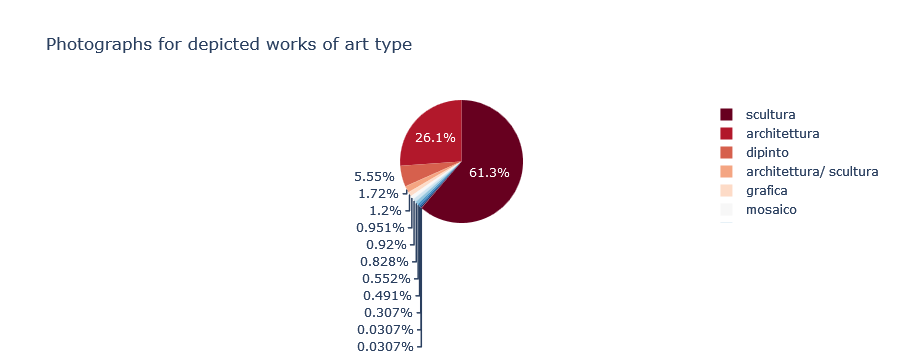

In [7]:
import pandas as pd
import plotly.express as px
%matplotlib inline

# open the data and counts photos by type of depicted work of art
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
OAt_df = pd.DataFrame(data_df["OGTT_OAtype"].value_counts().reset_index().values, columns=["OGTT_OAtype", "count"])

# create a pie chart on types
fig1_1 = px.pie(OAt_df, values='count', names="OGTT_OAtype",
            title='Photographs for depicted works of art type',
            color_discrete_sequence=px.colors.sequential.RdBu,
            labels = OAt_df['OGTT_OAtype'], hover_name = 'OGTT_OAtype',
            hover_data = {'OGTT_OAtype':False}
            )

fig1_1.write_html("data/3_data_viz/1.1.html")
fig1_1.show()

### 3.1.2 Works of art for object type - bar chart

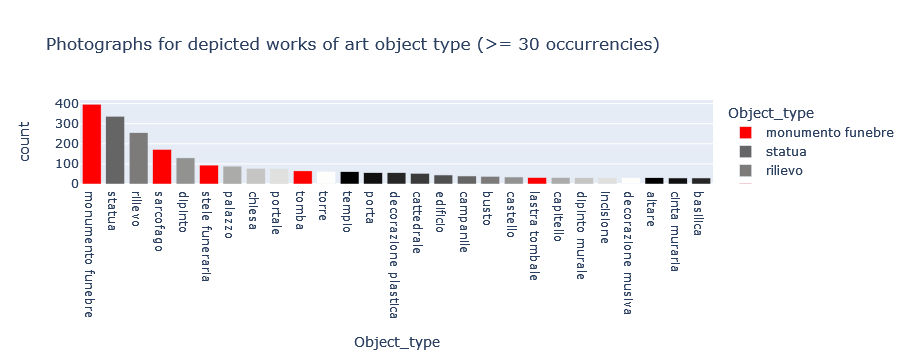

In [8]:
# open the data and counts photos by object_type of depicted work of art
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
OA_object_type_df = pd.DataFrame(data_df["OGTDOA_OAsubj_sub"].value_counts().reset_index().values, columns=["OGTDOA_OAsubj_sub", "count"])
OA_object_type_df = OA_object_type_df.rename(columns={"OGTDOA_OAsubj_sub": "Object_type"})

#filter for more than 30 occurrencies
OA_object_type_df = OA_object_type_df[OA_object_type_df["count"]>=30]

fig1_2 = px.bar(OA_object_type_df, x="Object_type", y="count",
                title="Photographs for depicted works of art object type (>= 30 occurrencies)",
                color="Object_type",
                color_discrete_sequence=px.colors.sequential.gray,
                color_discrete_map={'monumento funebre' : "red",
                                    'sarcofago' : "red",
                                    'stele funeraria' : "red",
                                    'lastra tombale' : "red",
                                    'tomba' : "red",
                                    },
                labels = None,
                hover_data = {'Object_type':False, 'count':True}
                  )
fig1_2.write_html("data/3_data_viz/1.2.html")
fig1_2.show()

### 3.1.3 Works of art for current location - map

In [9]:
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
country_town_type = data_df[["OGTT_OAtype", "PVCS_OAcountry", 'PVCC_OAtown']]

country_town_type = country_town_type.groupby(['PVCS_OAcountry', 'PVCC_OAtown', 'OGTT_OAtype']).size().reset_index()
country_town_type.columns = ["country", "place", "type", "count"]

#add geoloc infos to the data
geo_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8")
country_town_type = country_town_type.merge(geo_df, how='left', on="place")

print(country_town_type.head())

   country       place          type  count  Unnamed: 0        lat       lon
0  Algeria      Algeri  architettura     10         285  28.000027  2.999983
1  Algeria      Algeri      scultura      3         285  28.000027  2.999983
2  Algeria  Costantina  architettura      2         287  36.364519  6.608260
3  Algeria   Mansourah  architettura      4         288  34.873317 -1.330265
4  Algeria     Tazoult  architettura      1         290  35.486009  6.253610


In [11]:
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
country_town_type = data_df[["OGTT_OAtype", "PVCS_OAcountry", 'PVCC_OAtown']]

country_town_type = country_town_type.groupby(['PVCS_OAcountry', 'PVCC_OAtown', 'OGTT_OAtype']).size().reset_index()
country_town_type.columns = ["country", "place", "type", "count"]

#add geoloc infos to the data
geo_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8")
country_town_type = country_town_type.merge(geo_df, how='left', on="place")

print(country_town_type.head())

   country       place          type  count  Unnamed: 0        lat       lon
0  Algeria      Algeri  architettura     10         285  28.000027  2.999983
1  Algeria      Algeri      scultura      3         285  28.000027  2.999983
2  Algeria  Costantina  architettura      2         287  36.364519  6.608260
3  Algeria   Mansourah  architettura      4         288  34.873317 -1.330265
4  Algeria     Tazoult  architettura      1         290  35.486009  6.253610


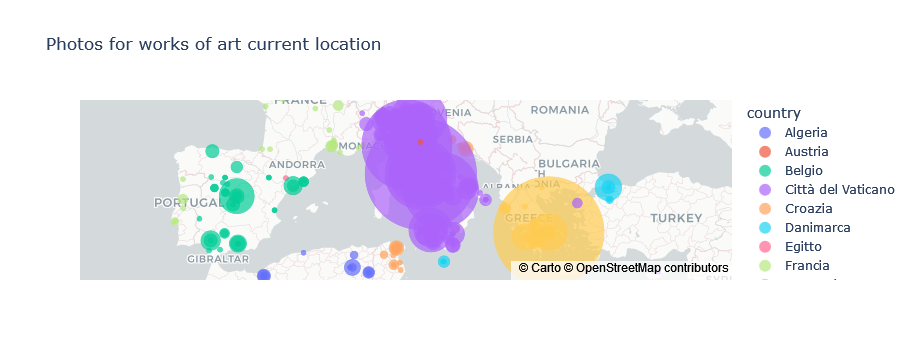

In [10]:
fig1_3 = px.scatter_mapbox(country_town_type,
                           lon=country_town_type['lon'], lat=country_town_type['lat'],
                           size=pd.to_numeric(country_town_type["count"]),
                           zoom=3,
                            color=country_town_type['country'],
                            color_continuous_scale=px.colors.cyclical.Twilight,
                            title="Photos for works of art current location",
                            size_max=80,
                            labels=country_town_type['type'], hover_name='place',
                            hover_data={'place':False, 'lat':False, 'lon':False})

fig1_3.update_layout(mapbox_style='carto-positron')
fig1_3.write_html("data/3_data_viz/1.3__.html")
fig1_3.show()

## 3.2 Photographers

### 3.2.1 Photographs for photographers - barchart

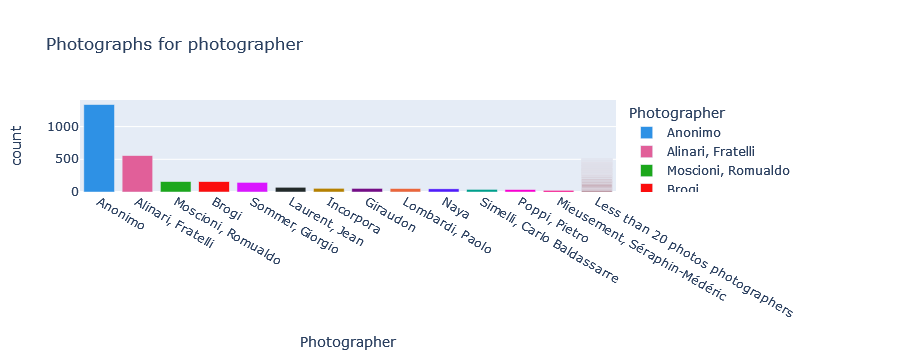

In [12]:
ph_df = pd.read_csv("data/2.1_PHfreq.csv", encoding="utf-8")
ph_df_main = ph_df.rename(columns={"AUFN_Faut": 'Photographer'})
ph_df_main.loc[ph_df_main['count'] < 20, 'Photographer'] = 'Less than 20 photos photographers'


fig2_1 = px.bar(ph_df_main, x="Photographer", y="count",
                title="Photographs for photographer",
                color="Photographer",
                color_discrete_sequence=px.colors.qualitative.Dark24,
                labels = ph_df_main['Photographer'], hover_name = 'Photographer',
                hover_data = {'Photographer': False, 'workplace': True}
              )

fig2_1.write_html("data/3_data_viz/2.1.html")
fig2_1.show()

### 3.2.2 Anonymous photographers: depicted works of art locations and types - barchart

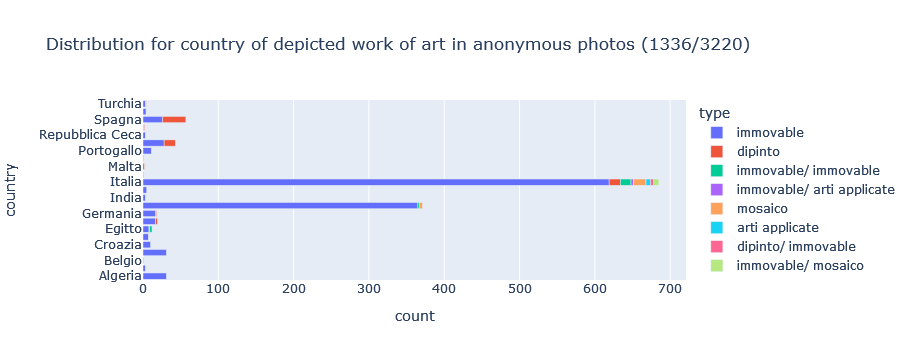

In [13]:
#open the source data, filter for anonymous photographs and extract places and type columns
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
ph_anonymous_df = data_df[data_df.AUFN_Faut == "Anonimo"]
ph_anonymous_df = ph_anonymous_df[["AUFN_Faut", 'PVCS_OAcountry', 'OGTT_OAtype', 'PVCC_OAtown']]

#rename "immovable" all the immovable works of art types
ph_anonymous_df = ph_anonymous_df.replace(to_replace ='architettura\ scultura|architettura|scultura|complesso archeologico|sito archeologico', value = 'immovable', regex = True)

#group by type and rename the columns
ph_anonymous_by_country_type = ph_anonymous_df.groupby(['PVCS_OAcountry', 'OGTT_OAtype']).size().reset_index()
ph_anonymous_by_country_type.columns = ["country", "type", "count"]

fig2_2 = px.bar(ph_anonymous_by_country_type,
                x="count", y="country", color="type",
                title="Distribution for country of depicted work of art in anonymous photos (1336/3220)",
                #color_discrete_sequence=px.colors.sequential.Brwnyl,
                )

fig2_2.write_html("data/3_data_viz/2.2.html")
fig2_2.show()

### 3.2.3 Anonymous photographers: immovable depicted works of art locations - map

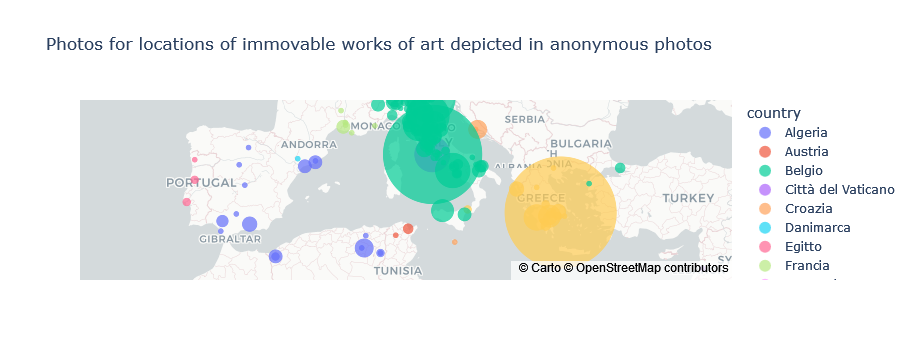

In [14]:
'''let's do the same steps of 3.2.2
#open the source data, filter for anonymous photographs and extract places and type columns
data_df = pd.read_csv("data/1.1_F_OA_selected_data.csv", encoding="UTF-8")
ph_anonymous_df = data_df[data_df.AUFN_Faut == "Anonimo"]
ph_anonymous_df = ph_anonymous_df[["AUFN_Faut", 'PVCS_OAcountry', 'OGTT_OAtype', 'PVCC_OAtown']]

#rename "immovable" all the immovable works of art types
ph_anonymous_df = ph_anonymous_df.replace(to_replace ='architettura\ scultura|architettura|scultura|complesso archeologico|sito archeologico', value = 'immovable', regex = True)
'''

#filter just the immovable type and group by country-town; rename the columns
ph_anonymous_geo = ph_anonymous_df[ph_anonymous_df.OGTT_OAtype == "immovable"]
ph_anonymous_geo = ph_anonymous_geo.groupby(['PVCS_OAcountry', 'PVCC_OAtown']).size().reset_index()
ph_anonymous_geo.columns = ["country", "place", "count"]

#add geoloc infos to the data
geo_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="UTF-8")
ph_anonymous_geo = ph_anonymous_geo.merge(geo_df, how='left', on="place")

fig2_3_bis = px.scatter_mapbox(ph_anonymous_geo,
                           lon=ph_anonymous_geo['lon'], lat=ph_anonymous_geo['lat'],
                           size=pd.to_numeric(ph_anonymous_geo["count"]),
                           zoom=3,
                            color=ph_anonymous_geo['country'],
                            color_continuous_scale=px.colors.cyclical.Twilight,
                            title="Photos for locations of immovable works of art depicted in anonymous photos",
                            size_max=80,
                            labels=ph_anonymous_geo['place'], hover_name='place', #rinomina in city
                            hover_data={'place':False, 'lat':False, 'lon':False})

# mapbox style
fig2_3_bis.update_layout(mapbox_style='carto-positron')
fig2_3_bis.write_html("data/2_data_viz/2.3.bis.html")
fig2_3_bis.show()

## 3.3 Annotations

### 3.3.1 Complete/incomplete/missing transcriptions - pie chart

       status  count
0    complete   1424
1  incomplete    412
2     missing   1475


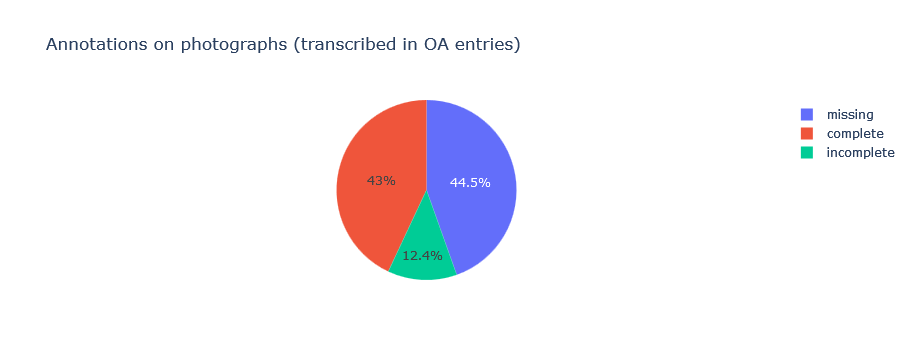

In [15]:
import pandas as pd
import plotly.express as px

#extract data from enhanched df
data_df = pd.read_csv('data/1.3_merged_md_unstructured.csv')
status_year_df = data_df[["status", "DTZG_OAcentury"]]
status_df = status_year_df.groupby(["status"]).size().reset_index()
# rename the columns
status_df.columns = ["status", "count"]
print(status_df.head())

fig3_1 = px.pie(status_df, values='count', names="status",
              title='Annotations on photographs (transcribed in OA entries)',
                color_discrete_map={'complete': "211, 156, 131",
                                    "incomplete": "224, 194, 162",
                                    "missing": "237, 229, 207", },
                labels = status_df['status'], hover_name='status',
              hover_data = {'status': True},
             )

fig3_1.show()
fig3_1.write_html("data/3_data_viz/3.1.html")

### 3.3.1 Complete/incomplete/missing transcriptions for works of art century - barchart
#### Prepare the data

In [16]:
#let's do the same steps of 3.3.1
'''import pandas as pd
import plotly.express as px
#extract data from enhanched df
data_df = pd.read_csv('data/1.3_merged_md_unstructured.csv')
status_year_df = data_df[["status", "DTZG_OAcentury"]]
'''
# group rows by period and year, hence add a column with the counting of collections rename the column and have a look
data_by_century = status_year_df.groupby(["DTZG_OAcentury", "status"]).size().reset_index()
data_by_century.columns = ["century", "status", "count"]
print(data_by_century.head())

#save this first extraction
data_by_century.to_csv("data/1_working_data/3.3.2_centuries_1.csv", encoding="UTF-8")

       century      status  count
0       sec. I    complete     44
1       sec. I  incomplete     15
2       sec. I     missing     35
3      sec. I   incomplete      1
4  sec. I a.C.    complete     31


#### Clean and check

In [17]:
#refine the results
#in case of more than a date, consider just the first one
data_by_century = data_by_century.replace(to_replace ='sec. |,.*', value = '', regex = True)
#in case of a range (es. sec. I a.C./ I ) consider the last one
data_by_century = data_by_century.replace(to_replace ='.*/', value = '', regex = True)
#remove white spaces
data_by_century = data_by_century.replace(to_replace ='^ ', value = '', regex = True)

#groupby the cleaned df and save it for further manual checks
data_by_century = data_by_century.groupby(['century','status'], as_index=False)['count'].sum()
data_by_century.to_csv("data/1_working_data/3.3.2_centuries_2.csv", encoding="UTF-8")

# #manual revision, saved in data/1_working_data/3.3.2_centuries_3.csv, have a look
data_by_century_rev = pd.read_csv('data/1_working_data/3.3.2_centuries_3.csv', encoding="UTF-8")
print(data_by_century_rev.head(50))

         century      status  count
0   a.C. VI-XXVI    complete     57
1   a.C. VI-XXVI  incomplete     15
2   a.C. VI-XXVI     missing     62
3         a.C. V    complete    129
4         a.C. V  incomplete     19
5         a.C. V     missing     43
6        a.C. IV    complete    113
7        a.C. IV  incomplete     19
8        a.C. IV     missing     19
9       a.C. III    complete     19
10      a.C. III  incomplete      7
11      a.C. III     missing     22
12       a.C. II    complete     21
13       a.C. II  incomplete     10
14       a.C. II     missing     11
15        a.C. I    complete     49
16        a.C. I  incomplete     18
17        a.C. I     missing     39
18             I    complete     62
19             I  incomplete     18
20             I     missing     57
21            II    complete     86
22            II  incomplete     23
23            II     missing     62
24           III    complete     30
25           III  incomplete     12
26           III     missing

#### Set the plot

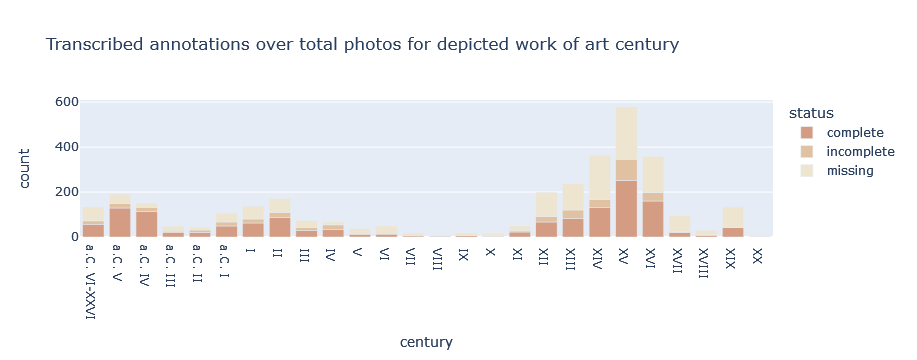

In [18]:
fig3_3_2 = px.bar(data_by_century_rev,
                x="century", y="count", color="status",
                title="Transcribed annotations over total photos for depicted work of art century",
                #color_discrete_sequence=px.colors.sequential.Brwnyl
                color_discrete_map={ # replaces default color mapping by value
                "complete": "rgb(211, 156, 131)", "incomplete": "rgb(224, 194, 162)", "missing": "rgb(237, 229, 207)"},
                )

fig3_3_2.show()
fig3_3_2.write_html("data/3_data_viz/3.3.html")

### 3.3.3 Wordcloud on corpora
Compare the wordcloud of whole corpus of annotations and the restricted one to personal experiences.

In [19]:
!pip install wordcloud
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# word cloud library
from wordcloud import WordCloud

# matplotlib library
import matplotlib.pyplot as plt

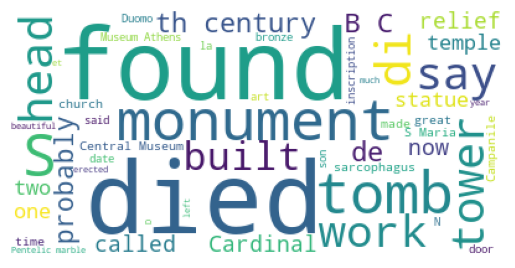

<Figure size 640x480 with 0 Axes>

In [20]:
with open("data/1.2_annotations_corpus.txt", mode="r") as f:
    text = f.read()

fig3_3_1 = WordCloud(
                    background_color = 'white',
                    max_font_size=80, max_words=50).generate(text)

plt.imshow(fig3_3_1)
plt.axis('off') # to off the axis of x and y
plt.show()
plt.savefig('data/3_data_viz/3.3.1.svg')

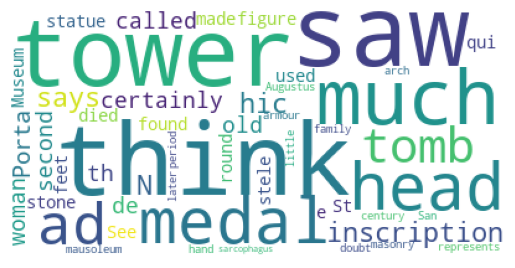

<Figure size 640x480 with 0 Axes>

In [21]:
with open("data/2.3_annotations_restricted_corpus.txt", mode="r") as f:
    text_restricted = f.read()

fig3_3_2 = WordCloud(
                    background_color = 'white',
                    max_font_size=80, max_words=50).generate(text_restricted)

plt.imshow(fig3_3_2)
plt.axis('off') # to off the axis of x and y
plt.show()
plt.savefig('data/3_data_viz/3.2.2.jpg')

## 4.  Derived infos: dated and located personal experiences from annotations - map 

In [22]:
#open the visited places and the PLcoordinates df, merge the data and check
visited_places_df = pd.read_csv("data/1_working_data/2.3_2_time_place_df.csv", encoding="utf8")
places_df = pd.read_csv("data/2.2_PLcoordinates.csv", encoding="utf-8")
visited_place_coor = visited_places_df.merge(places_df, how='left', on="place")
visited_place_coor.drop('Unnamed: 0', axis=1, inplace=True)
print(visited_places_df.head())


        Inv                                               Note    place  date
0   sup 218  Corneto Vitelleschi. Court of Cardinal Vitelle...  Corneto  1861
1  sup 1351  This grand headless Etruscan lady came with th...   Chiusi  1866
2  sup 1368  The sarcophagus is of solid porphyry; the six ...  Palermo  1892
3  sup 1811  Agrippa. The celebrated statue which the great...    Corfù  1894
4  sup 2470  This is the fine tower built in the 13.th cent...    Atene  1865


In [23]:
#open the source data to have photos ids, merge the data, rename and check
data_df = pd.read_csv('data/1.1_F_OA_selected_data.csv')
photo_ids = data_df[["INVN_F", "sercdf_F_ser"]]
photo_ids = photo_ids.rename(columns={"sercdf_F_ser": "Fentry_id", "INVN_F":"Inv"})

visited_places_data = visited_place_coor.merge(photo_ids, how='left', on="Inv")
visited_places_data = visited_places_data.rename(columns={"Note":"Note_one_line",
                                                      "lat":"lats", "lon":"lons"})
print(visited_places_data.head())

        Inv                                      Note_one_line    place  date  \
0   sup 218  Corneto Vitelleschi. Court of Cardinal Vitelle...  Corneto  1861   
1  sup 1351  This grand headless Etruscan lady came with th...   Chiusi  1866   
2  sup 1368  The sarcophagus is of solid porphyry; the six ...  Palermo  1892   
3  sup 1811  Agrippa. The celebrated statue which the great...    Corfù  1894   
4  sup 2470  This is the fine tower built in the 13.th cent...    Atene  1865   

        lats       lons  Fentry_id  
0  42.792809  13.436531     106976  
1  43.016508  11.947712     107660  
2  38.111227  13.352443     107699  
3  39.591337  19.859619     108071  
4  37.983941  23.728305     108395  


In [24]:
#create two new columns for breaking the text in visualization and add Fentry url
#save the new file and check
visited_places_data['Note'] = visited_places_data.apply(lambda row: ('<br>'.join(str(row.Note_one_line)[i:i+50] for i in range(0, len(str(row.Note_one_line)), 50))), axis = 1)
visited_places_data['photo_url'] = visited_places_data.apply(lambda row: ('<a href="http://catalogo.fondazionezeri.unibo.it/scheda/fotografia/'+str(row.Fentry_id)+' target="_blank">http://catalogo.fondazionezeri.unibo.it/scheda/fotografia/'+str(row.Fentry_id)+'</a>'), axis = 1)

visited_places_data.to_csv("data/1_working_data/3.4.1_visited_places_data.csv", encoding="UTF-8")
print(visited_place_coor.head())

        Inv                                               Note    place  date  \
0   sup 218  Corneto Vitelleschi. Court of Cardinal Vitelle...  Corneto  1861   
1  sup 1351  This grand headless Etruscan lady came with th...   Chiusi  1866   
2  sup 1368  The sarcophagus is of solid porphyry; the six ...  Palermo  1892   
3  sup 1811  Agrippa. The celebrated statue which the great...    Corfù  1894   
4  sup 2470  This is the fine tower built in the 13.th cent...    Atene  1865   

         lat        lon  
0  42.792809  13.436531  
1  43.016508  11.947712  
2  38.111227  13.352443  
3  39.591337  19.859619  
4  37.983941  23.728305  


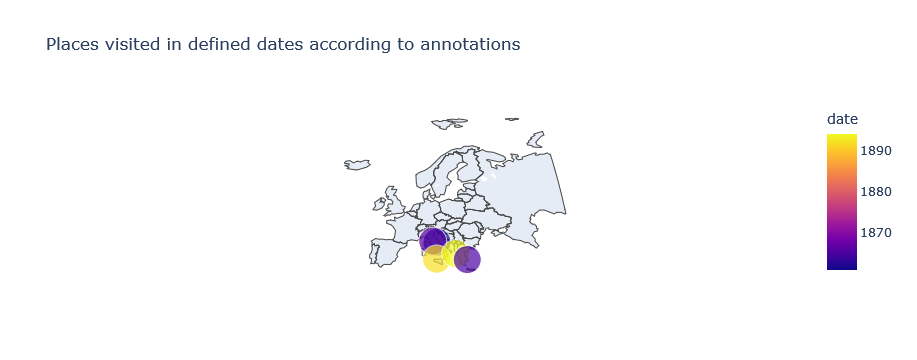

In [25]:
#set the plot

import plotly.express as px
fig = px.scatter_geo(visited_places_data, color="date",
                lat=visited_places_data["lats"].values.tolist(),
                  lon=visited_places_data["lons"].values.tolist(),
                  title="Places visited in defined dates according to annotations", size="date",
                     projection="natural earth", scope="europe",
            labels = visited_places_data['place'], hover_name='place',
            hover_data = {'place':False, 'Inv':True, 'photo_url':True, 
                          'Note':True, 'lats': False, 'lons':False}
            )
fig.show()
fig.write_html("data/3_data_viz/4.1.html")